The final result of this comparison gave us a clear picture: Zarr is very suitable for our application due to the combination of speed and efficient storage, but other formats (HDF5, pickle) can also be practical in certain cases.

We ultimately chose **Zarr** as our final format because it combines fast, chunked access with good compression, making it well-suited for large datasets like ours. It allows us to read and write only the relevant chunks of data (improving both performance and memory usage) and can be used either locally or on cloud storage without much extra effort. Additionally Zarr is open source which promotes trust and allows you to understand zarr from the code.

#### [Zarr illustration](https://github.com/zarr-developers/zarr-illustrations-falk-2022)
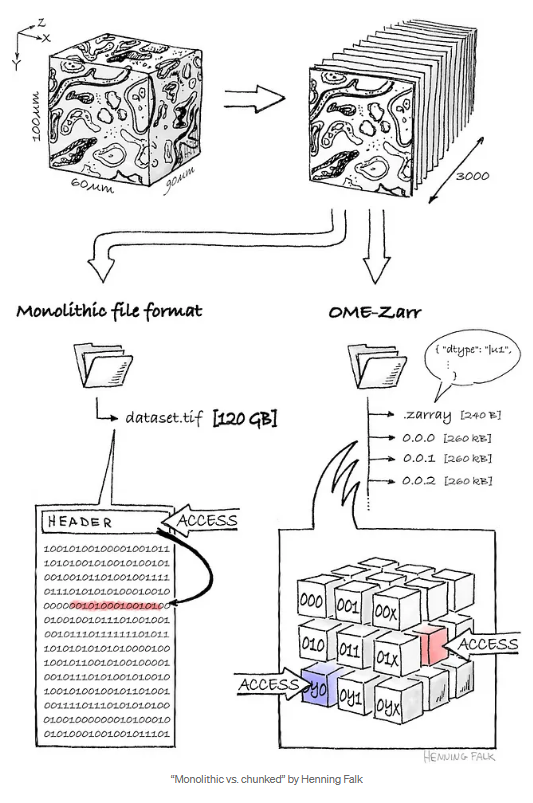

## How do you use Zarr?

Below is a step-by-step explanation of how the script [Zarr_inladen](https://github.com/HHS-ADSAI/DL3-2024-A/blob/main/zarr/Zarr_inladen.ipynb) —whether `.txt`, `.csv`, or `.npy`—into Zarr format. The main idea is: load each file into a DataFrame, then write that DataFrame into a Zarr store located on disk.

---

## 1. **Initial Setup and Path Checking**

```python
if os.path.exists(path + "vibration_101-20240512102014.txt"):
    print("The file exists")
else:
    raise FileNotFoundError(f"The file {path + 'vibration_101-20240512102014.txt'} does not exist")
```
- We verify that the specified path and a test file exist. This ensures we don’t run into `FileNotFoundError` when we start loading data.

---

## 2. **Data-Loading Utility Functions**

### a) `load_data(file_name, header='infer')`
```python
def load_data(file_name, header='infer'):
    file_path = (path + file_name)
    df = pd.read_csv(file_path, header=header)
    return df
```
- **Purpose**: Read a `.txt` or `.csv` file via `pandas.read_csv()`, returning a DataFrame.
- **Why**: Many of our vibration and temperature files are in plain text or CSV format.

### b) `tranpose_vibration(df)`
```python
def tranpose_vibration(df):
    df_import = pd.DataFrame()
    timestamps = []
    data_values = [df.iloc[ii, i + 2] for ii in range(100) for i in range(25000)]
    
    for i in range(100):
        timestamps.append(df.iloc[i, 0])
        timestamps.extend([None] * 24999)
    
    df_import['Timestamp'] = timestamps
    df_import['Data'] = data_values
    return df_import
```
- **Purpose**: Rearrange vibration data from a wide format into a “long” format, with a `Timestamp` column and a `Data` column.
- **Why**: The original text files for vibration often store 100 rows × 25,000 columns. We flatten/transpose them so each row in the resulting DataFrame has one data point.

### c) `load_npy(file_name)`
```python
def load_npy(file_name):
    file_to_load = os.path.join(path, file_name)
    npy_data = np.load(file_to_load)
    df = pd.DataFrame(npy_data)
    df = df.T
    return df
```
- **Purpose**: Load `.npy` files (often used for arrays) into a Pandas DataFrame and transpose them if needed.
- **Why**: Fiber data is often saved in `.npy` format. We want to keep a consistent DataFrame structure before saving to Zarr.

### d) `load_csv(file_name)`
```python
def load_csv(file_name):
    file_to_load = os.path.join(path, file_name)
    return pd.read_csv(file_to_load)
```
- **Purpose**: Same idea as `load_data()`, but specifically for CSV files with default arguments.

---

## 3. **Preprocessing: Sanitizing Column Names**

```python
def sanitize_column_names(df):
    df.columns = df.columns.str.replace(r"[#\[\]\s]", "_", regex=True)
    return df
```
- **Purpose**: Remove or replace any special characters (`#`, `[`, `]`, space) in column names with underscores `_`.
- **Why**: Zarr datasets and other data stores can have issues with unusual column names. By ensuring the column names are standard, we avoid errors down the line.

---

## 4. **Core Logic: `save_to_zarr(dataframe, zarr_path, group_name, sanitize=True)`**

```python
def save_to_zarr(dataframe, zarr_path, group_name, sanitize=True):
    os.makedirs(os.path.dirname(zarr_path), exist_ok=True)
    
    zarr_store = zarr.open(zarr_path, mode='a')
    group = zarr_store.require_group(group_name)
    
    if sanitize:
        dataframe = sanitize_column_names(dataframe)

    if len(group):
        for column in dataframe.columns:
            if column in group:
                group[column].append(dataframe[column].to_numpy())
            else:
                group.create_dataset(
                    column,
                    data=dataframe[column].to_numpy(),
                    chunks=True,
                    overwrite=False,
                    appendable=True,
                )
    else:
        for column in dataframe.columns:
            group.create_dataset(
                column,
                data=dataframe[column].to_numpy(),
                chunks=True,
                overwrite=False,
            )

    group.attrs['columns'] = list(dataframe.columns)
    group.attrs['dtypes'] = dataframe.dtypes.apply(str).to_dict()
    print(f"Data saved to Zarr group '{group_name}'")
```

1. **Open/Append Zarr store**:  
   - `zarr.open(zarr_path, mode='a')` creates or opens a Zarr file in append mode.
   - `group = zarr_store.require_group(group_name)` ensures we have a Zarr group named after our data category (e.g., `vibration_101` or `fibers_1`).

2. **Sanitize columns** (optional):  
   - If `sanitize=True`, run `sanitize_column_names` on the DataFrame.

3. **Create or Append datasets**:  
   - If the group is **empty**, create datasets from each column in the DataFrame.  
   - If the group is **not empty**, that means we’ve already created some columns in a previous run. So we either **append** new data or create a new column if needed.

4. **Store metadata**:  
   - `group.attrs['columns']`: the column names.  
   - `group.attrs['dtypes']`: each column’s data type as a string.

---

## 5. **Putting It All Together: Saving Each Data Category**

### a) Environment RPM and Temperature
```python
for file_name in os.listdir(path):
    if file_name.startswith("environment_rpm") and file_name.endswith(".csv"):
        dataframe = load_csv(file_name)
        group_name = "environment_rpm"
        save_to_zarr(dataframe, zarr_path, group_name)

for file_name in os.listdir(path):
    if file_name.startswith("environment_temperature") and file_name.endswith(".csv"):
        dataframe = load_csv(file_name)
        group_name = "environment_temperature"
        save_to_zarr(dataframe, zarr_path, group_name)
```
- **Process**:  
  1. Check if the file name starts with `environment_rpm` (or `environment_temperature`) and ends with `.csv`.  
  2. Load into a DataFrame.  
  3. Save to the **`environment_rpm`** (or `environment_temperature`) group in the Zarr store.

### b) Load Temperature (Text Files)
```python
for file_name in os.listdir(path):
    if file_name.startswith("load_temperature") and file_name.endswith(".txt"):
        dataframe = load_data(file_name, header=None)
        group_name = "load_temperature"
        save_to_zarr(dataframe, zarr_path, group_name, sanitize=False)
```
- Similar logic: find `.txt` files named like `load_temperature-...`, read them, and then save them to `load_temperature` group.

### c) Fibers (`.npy` files)
```python
def save_fibers_to_zarr(fiber_number):
    files_to_process = [
        file_name for file_name in os.listdir(path) 
        if file_name.startswith(f"fibers_{fiber_number}") and file_name.endswith(".npy")
    ]
    
    for file_name in files_to_process:
        dataframe = load_npy(file_name)
        group_name = f"fibers_{fiber_number}"
        save_to_zarr(dataframe, zarr_path, group_name, sanitize=False)
```
- **Process**:  
  1. Look for `.npy` files with a given prefix, e.g., `fibers_1_20240508...npy`.  
  2. Load each `.npy` into a DataFrame.  
  3. Append or create the dataset in the **`fibers_X`** group (where `X` is the fiber number).

### d) Vibration Data (Text Files with Transposition)
```python
def save_vibration_to_zarr(vibration_number):
    files_to_process = [
        file_name for file_name in os.listdir(path) 
        if file_name.startswith(f"vibration_{vibration_number}") 
           and file_name.endswith(".txt") 
           and not file_name.endswith("oct.txt")
    ]
    
    for file_name in files_to_process:
        raw_data = load_data(file_name, header=None)
        dataframe = tranpose_vibration(raw_data)

        group_name = f"vibration_{vibration_number}"
        save_to_zarr(dataframe, zarr_path, group_name, sanitize=False)
```
- **Process**:
  1. Find `vibration_{vibration_number}-something.txt` files, excluding `oct.txt`.  
  2. **Read** them with `load_data(...)`.  
  3. **Transpose** the wide data into a “long” DataFrame via `tranpose_vibration()`.  
  4. Save or append to the **`vibration_X`** group in Zarr.

---


### **Overall Flow** 

1. **Identify** the files to process by pattern (e.g. `"environment_rpm" + ".csv"`, or `"fibers_1" + ".npy"`).  
2. **Load** each file into a DataFrame (with specialized logic for each format).  
3. **Preprocess** if necessary (transposing vibration data, sanitizing column names).  
4. **Save** to Zarr using `save_to_zarr()`, which either creates a new dataset group or appends to an existing one.





Now you should have the Zarr version of all the converted files. Structure should be like the following image:

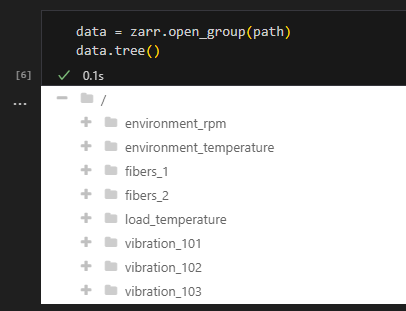


### How to load the Data in Zarr structure?

Loading the Zarr Data also takes a function, each function to load the data used in [notebook](https://github.com/HHS-ADSAI/DL3-2024-A/blob/main/notebooks/1.ipynb) is stored in [functions](https://github.com/HHS-ADSAI/DL3-2024-A/blob/main/notebooks/functions.py)


```python
from functions import load_fiber_data, load_vibration_data, load_other
fiber_number = 1
sensor_numbers = [1, 2, 3, 4, 5]
vibration_number = 101

fiber_1 = load_fiber_data(path, fiber_number, sensor_numbers)
fiber_2 = load_fiber_data(path, fiber_number + 1, sensor_numbers)
vibration_101 = load_vibration_data(path, vibration_number)
vibration_102 = load_vibration_data(path, vibration_number + 1)
vibration_103 = load_vibration_data(path, vibration_number + 2)
df_rpm = load_other(path, 'environment_rpm')
df_env = load_other(path, 'environment_temperature')
df_temp = load_other(path, 'load_temperature')
```


---
#### Explaining the functions in functions.py to load Zarr data into Dataframes

## 1. `load_fiber_data(zarr_path, fiber_number, sensor_numbers)`

### **Purpose**  
Load all the sensors from each fiber sensor:
- fiber_number `"1"` or `"2"`. This is the sensor
- sensor_numbers `"1"`, `"2"`, … are the **sensor** readings.

### **Code Breakdown**

```python
def load_fiber_data(zarr_path, fiber_number, sensor_numbers):
    ...
```
1. **Parameters**  
   - **`zarr_path`**: File path to the Zarr store on disk.  
   - **`fiber_number`**: Identifies which fiber group to load `"fibers_1"`, `"fibers_2"`  
   - **`sensor_numbers`**: Which sensor columns within the fiber group to load.

2. **Convert single sensor_number to a list**  
   ```python
   if isinstance(sensor_numbers, int):
       sensor_numbers = [sensor_numbers]
   ```
   Ensures we always iterate over a list, even if a single sensor number is passed in.

3. **Open the Zarr store in read-only mode**  
   ```python
   zarr_store = zarr.open(zarr_path, mode='r')
   ```
   - **Why**: We’re only reading data, so `mode='r'`.

4. **Access the correct fiber group**  
   ```python
   group_name = f"fibers_{fiber_number}"
   if group_name not in zarr_store:
       raise KeyError(...)
   fiber_group = zarr_store[group_name]
   ```
   - **Check existence**: If `fibers_{fiber_number}` doesn’t exist, raise an error showing which groups *do* exist.

5. **Load the timestamps**  
   ```python
   timestamps = fiber_group['0'][:]
   ```
   - **Why `'0'`**: Conventionally, `'0'` is the dataset holding timestamps in this setup.

6. **Initialize a dictionary to store columns**  
   ```python
   data = {'timestamp': timestamps}
   ```
   - We start with a `'timestamp'` key, containing all timestamps.

7. **Load each requested sensor**  
   ```python
   for s_num in sensor_numbers:
       s_str = str(s_num)
       values = fiber_group[s_str][:] 
       ...
       data[f'sensor_{s_num}'] = values
   ```
   - Convert the sensor number to a string (to match dataset keys like `'1'`, `'2'`).
   - Read the data array from Zarr: `fiber_group[s_str][:]`.
   - Check that the length of the sensor data matches the length of the timestamps.
   - Store it under a key like `'sensor_1'` or `'sensor_2'`.

8. **Convert to a Pandas DataFrame**  
   ```python
   df = pd.DataFrame(data)
   return df
   ```
   - The `dict` has `'timestamp'` plus one column per sensor, so we get a structure like:

     | timestamp | sensor_1 | sensor_2 | … |
     |-----------|----------|----------|---|

---

## 2. `load_vibration_data(zarr_path, vibration_number)`

### **Purpose**  
Load the transposed vibration data from the Zarr store. Each vibration dataset group typically has two datasets:
- `Timestamp`
- `Data`

### **Code Breakdown**

```python
def load_vibration_data(zarr_path, vibration_number):
    ...
```

1. **Parameters**  
   - **`zarr_path`**: Path to the Zarr store.  
   - **`vibration_number`**: Identifies which vibration group to load, e.g., `"vibration_101"`.

2. **Open the Zarr store in read-only mode**  
   ```python
   zarr_store = zarr.open(zarr_path, mode='r')
   ```
3. **Locate the vibration group**  
   ```python
   group_name = f"vibration_{vibration_number}"
   if group_name not in zarr_store:
       raise KeyError(...)
   vib_group = zarr_store[group_name]
   ```
   - If `"vibration_{vibration_number}"` doesn’t exist, raise an error.

4. **Check for `Timestamp` and `Data`**  
   ```python
   if 'Timestamp' not in vib_group or 'Data' not in vib_group:
       raise ValueError(...)
   ```
   - Ensures both datasets are present.

5. **Load arrays and validate alignment**  
   ```python
   timestamps = vib_group['Timestamp'][:]
   values = vib_group['Data'][:]
   if len(timestamps) != len(values):
       raise ValueError(...)
   ```
   - Make sure they’re the same length so we can pair them row-by-row.

6. **Create a DataFrame**  
   ```python
   df = pd.DataFrame({
       'timestamp': timestamps,
       'data': values
   })
   return df
   ```
   - DataFrame columns: `'timestamp'` and `'data'`.

---

## 3. `load_other(path, group_name)`

### **Purpose**  
Load any other data group (like `"environment_rpm"`, `"environment_temperature"`, or `"load_temperature"`) which may have different column names. Optionally check if a timestamp column (`'__time_UTC__s__'`) exists.

### **Code Breakdown**

```python
def load_other(path, group_name):
    ...
```

1. **Parameters**  
   - **`path`**: Zarr store path.  
   - **`group_name`**: `"environment_rpm"`, `"environment_temperature"`, or `"load_temperature"`

2. **Open the Zarr store (read-only)**  
   ```python
   zarr_store = zarr.open(path, mode='r')
   ```
3. **Check group existence**  
   ```python
   if group_name not in zarr_store:
       raise KeyError(...)
   data_group = zarr_store[group_name]
   ```
4. **Check for timestamps** (optional)  
   ```python
   timestamp_column = None
   if '__time_UTC__s__' in data_group:
       timestamp_column = '__time_UTC__s__'
       timestamps = data_group[timestamp_column][:]
   else:
       timestamps = None
   ```
   - **Why**: Some groups may have a special `'__time_UTC__s__'` dataset for timestamps; some may not.

5. **Load all other datasets**  
   ```python
   data_columns = [key for key in available_keys if key != timestamp_column]
   data = {col: data_group[col][:] for col in data_columns}
   ```
   - We gather each dataset under its column name, building a dictionary for DataFrame creation.

6. **Create the final DataFrame**  
   ```python
   if timestamps is not None:
       df = pd.DataFrame({
           'timestamp': timestamps,
           **data
       })
   else:
       df = pd.DataFrame(data)
   return df
   ```

---

## **Overall Flow**

- **1) Identify** which group you want to load: `fibers_{n}`, `vibration_{n}`, or a named group like `"environment_rpm"`.
- **2) Open** the Zarr store in read-only mode (`mode='r'`).
- **3) Validate** group existence and check for required datasets (like `'Timestamp'` or `'0'` for fiber timestamps).
- **4) Read** the arrays from Zarr into memory using `[:]` slicing.
- **5) Build** a  DataFrame, ensuring data alignment (same row count).
- **6) Return** the DataFrame for further analysis or visualization.





#### Notes
- **1)** Converting vibration data took around 6 hours for all files, with an error near the end and the final file: did not match the size of other vibration files.
- **2)** Loading all the data takes only 2,5 minutes on a good computer(takes around 10gb of ram)
- **3)** Converting the files to Zarr: Run the code only once, if you get an error and need to re-do it please delete current Zarr zip for the data. No need to delete the whole structure. Running the fiber converting twice for example could result into duplicate data.